The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Implementation of Multilayer Perceptrons
:label:`sec_mlp-implementation`

Multilayer perceptrons (MLPs) are not much more complex to implement than simple linear models. The key conceptual
difference is that we now concatenate multiple layers.


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
import torch.nn.init as init

## Implementation from Scratch

Let's begin again by implementing such a network from scratch.

### Initializing Model Parameters

Recall that Fashion-MNIST contains 10 classes,
and that each image consists of a $28 \times 28 = 784$
grid of grayscale pixel values.
As before we will disregard the spatial structure
among the pixels for now,
so we can think of this as a classification dataset
with 784 input features and 10 classes.
To begin, we will [**implement an MLP
with one hidden layer and 256 hidden units.**]
Both the number of layers and their width are adjustable
(they are considered hyperparameters).
Typically, we choose the layer widths to be divisible by larger powers of 2.
This is computationally efficient due to the way
memory is allocated and addressed in hardware.

Again, we will represent our parameters with several tensors.
Note that *for every layer*, we must keep track of
one weight matrix and one bias vector.
As always, we allocate memory
for the gradients of the loss with respect to these parameters.


In the code below we use `nn.Parameter`
to automatically register
a class attribute as a parameter to be tracked by `autograd` (:numref:`sec_autograd`).


In [ ]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

### Model

To make sure we know how everything works,
we will [**implement the ReLU activation**] ourselves
rather than invoking the built-in `relu` function directly.


In [ ]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

Since we are disregarding spatial structure,
we `reshape` each two-dimensional image into
a flat vector of length  `num_inputs`.
Finally, we (**implement our model**)
with just a few lines of code. Since we use the framework built-in autograd this is all that it takes.


In [ ]:
@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

### Training

Fortunately, [**the training loop for MLPs
is exactly the same as for softmax regression.**] We define the model, data, and trainer, then finally invoke the `fit` method on model and data.


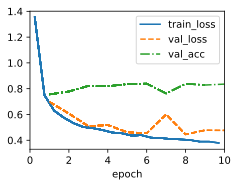

In [ ]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
trainer

## Concise Implementation

As you might expect, by relying on the high-level APIs, we can implement MLPs even more concisely.

### Model

Compared with our concise implementation
of softmax regression implementation
(:numref:`sec_softmax_concise`),
the only difference is that we add
*two* fully connected layers where we previously added only *one*.
The first is [**the hidden layer**],
the second is the output layer.


In [ ]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

Previously, we defined `forward` methods for models to transform input using the model parameters.
These operations are essentially a pipeline:
you take an input and
apply a transformation (e.g.,
matrix multiplication with weights followed by bias addition),
then repetitively use the output of the current transformation as
input to the next transformation.
However, you may have noticed that
no `forward` method is defined here.
In fact, `MLP` inherits the `forward` method from the `Module` class (:numref:`subsec_oo-design-models`) to
simply invoke `self.net(X)` (`X` is input),
which is now defined as a sequence of transformations
via the `Sequential` class.
The `Sequential` class abstracts the forward process
enabling us to focus on the transformations.
We will further discuss how the `Sequential` class works in :numref:`subsec_model-construction-sequential`.


### Training

[**The training loop**] is exactly the same
as when we implemented softmax regression.
This modularity enables us to separate
matters concerning the model architecture
from orthogonal considerations.


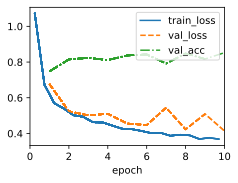

In [ ]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

## Summary

Now that we have more practice in designing deep networks, the step from a single to multiple layers of deep networks does not pose such a significant challenge any longer. In particular, we can reuse the training algorithm and data loader. Note, though, that implementing MLPs from scratch is nonetheless messy: naming and keeping track of the model parameters makes it difficult to extend models. For instance, imagine wanting to insert another layer between layers 42 and 43. This might now be layer 42b, unless we are willing to perform sequential renaming. Moreover, if we implement the network from scratch, it is much more difficult for the framework to perform meaningful performance optimizations.

Nonetheless, you have now reached the state of the art of the late 1980s when fully connected deep networks were the method of choice for neural network modeling. Our next conceptual step will be to consider images. Before we do so, we need to review a number of statistical basics and details on how to compute models efficiently.


## Exercises

1. Change the number of hidden units `num_hiddens` and plot how its number affects the accuracy of the model. What is the best value of this hyperparameter?
1. Try adding a hidden layer to see how it affects the results.
1. Why is it a bad idea to insert a hidden layer with a single neuron? What could go wrong?
1. How does changing the learning rate alter your results? With all other parameters fixed, which learning rate gives you the best results? How does this relate to the number of epochs?
1. Research different activations functions and try out them out. Which one works best?
1. Is there a difference between weight initializations of the network? Does it matter?
1. Let's optimize over all hyperparameters jointly, i.e., learning rate, number of epochs, number of hidden layers, and number of hidden units per layer.
    1. What is the best result you can get by optimizing over all of them?
    1. Why it is much more challenging to deal with multiple hyperparameters?
    1. Describe an efficient strategy for optimizing over multiple parameters jointly.


### **1.** Change the number of hidden units `num_hiddens` and plot how its number affects the accuracy of the model. What is the best value of this hyperparameter?

None
num_hiddens: 512


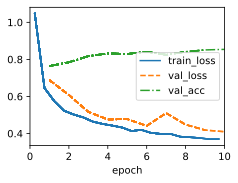

In [ ]:
num_hidden = 512
model = MLP(num_outputs=10, num_hiddens=num_hidden, lr=0.1)
print(trainer.fit(model, data))
print("num_hiddens: " + str(num_hidden))

None
num_hiddens: 1024


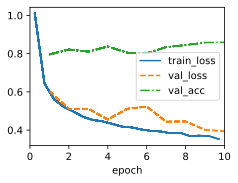

In [ ]:
num_hidden = 1024
model = MLP(num_outputs=10, num_hiddens=num_hidden, lr=0.1)
print(trainer.fit(model, data))
print("num_hiddens: " + str(num_hidden))

None
num_hiddens: 2048


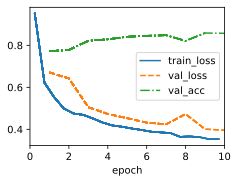

In [ ]:
num_hidden = 2048
model = MLP(num_outputs=10, num_hiddens=num_hidden, lr=0.1)
print(trainer.fit(model, data))
print("num_hiddens: " + str(num_hidden))

None
num_hiddens: 4096


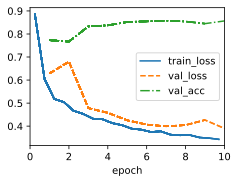

In [ ]:
num_hidden = 4096
model = MLP(num_outputs=10, num_hiddens=num_hidden, lr=0.1)
print(trainer.fit(model, data))
print("num_hiddens: " + str(num_hidden))

None
num_hiddens: 8192


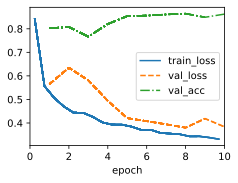

In [ ]:
num_hidden = 8192
model = MLP(num_outputs=10, num_hiddens=num_hidden, lr=0.1)
print(trainer.fit(model, data))
print("num_hiddens: " + str(num_hidden))

#### <font color='blue'>As mentioned, the layer widths should be divisible by larger powers of 2. This is computationally efficient due to the way memory is allocated and addressed in hardware. So the different numbers of hidden units was decided using larger powers of 2. Aside from the original hidden units which is 256, the model was trained through different values for num_hiddens particularly 512, 1024, 2048, 4096, and 8192. </font>

#### <font color='blue'> From 256 (original) until 4096, the accuracy steadily increased by a small amount nearing 0.9 accuracy. However, it became stagnant when it reached hidden units of 8192 as their accuracies can be seen as the same. </font>

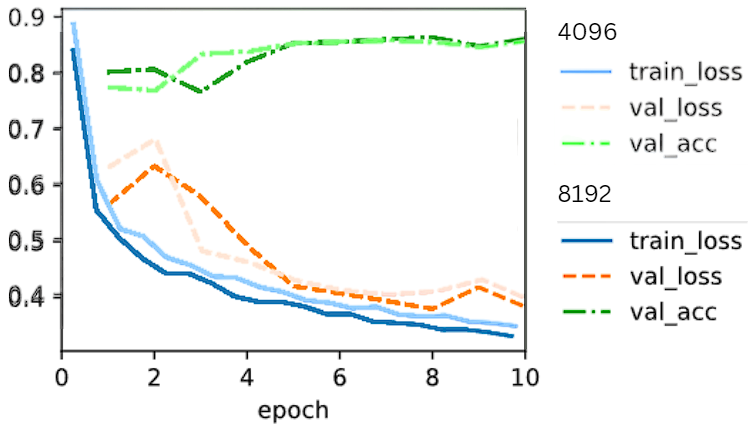

#### <font color='blue'> In this graph we compare the results of num_hidden values 4096 and 8192. It can be seen that the final accuracies are almost the same although 4096 had a higher initial loss.</font>

#### <font color='blue'> Based on these results, **the best value of this hyperparameter would be 4096**, although it had a slower convergence compared to lower hidden unit values.</font>

### **2.** Try adding a hidden layer to see how it affects the results.

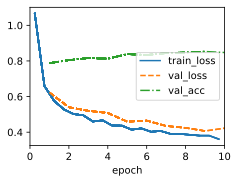

In [ ]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

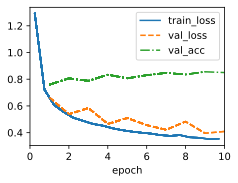

In [ ]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_hiddens),  # Additional hidden layer
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

#### <font color='blue'>Adding a hidden layer helps in increasing the model's capacity to learn more sophisticated patterns within the data. Based on the plots above, it can be seen that **there is no significant difference having an additional hidden layer.** </font>

### **3.** Why is it a bad idea to insert a hidden layer with a single neuron? What could go wrong?

In [ ]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

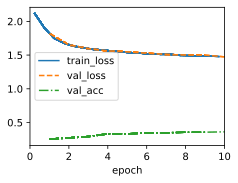

In [ ]:
model = MLP(num_outputs=10, num_hiddens=1, lr=0.1)
trainer.fit(model, data)

#### <font color='blue'>Inserting a hidden layer can cause **lack of non-linearity** which means that it can only perform linear transformations on the input data. This would also result in **linearity with the train_loss and val_loss, making them equal**, as seen in the plot above. Since the model cannot cannot capture complex, non-linear patterns between input data, it might **underperform on unseen data** because it **cannot generalize well beyond the training set** thus making the val_acc very low. </font>

### **4.** How does changing the learning rate alter your results? With all other parameters fixed, which learning rate gives you the best results? How does this relate to the number of epochs?

None
learning rate: 0.9


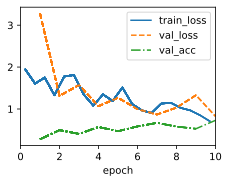

In [ ]:
learning_rate = 0.9
model = MLP(num_outputs=10, num_hiddens=256, lr=learning_rate)
print(trainer.fit(model, data))
print("learning rate: " + str(learning_rate))

None
learning rate: 0.1


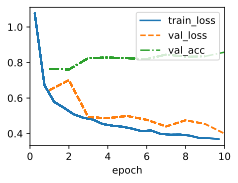

In [ ]:
learning_rate = 0.1
model = MLP(num_outputs=10, num_hiddens=256, lr=learning_rate)
print(trainer.fit(model, data))
print("learning rate: " + str(learning_rate))

None
learning rate: 0.01


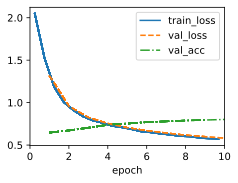

In [ ]:
learning_rate = 0.01
model = MLP(num_outputs=10, num_hiddens=256, lr=learning_rate)
print(trainer.fit(model, data))
print("learning rate: " + str(learning_rate))

None
learning rate: 0.001


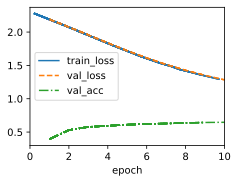

In [ ]:
learning_rate = 0.001
model = MLP(num_outputs=10, num_hiddens=256, lr=learning_rate)
print(trainer.fit(model, data))
print("learning rate: " + str(learning_rate))

#### <font color='blue'>- As shown above, having a high learning rate such as 0.9 can cause the training process to diverge thus increasing the loss and the model performs poorly.

#### <font color='blue'>- lower learning rate can cause slow convergence and the training process getting stuck at local minima as seen with learning rates of 0.01 and 0.001. </font>

#### <font color='blue'>- With all other parameters fixed, **a learning rate of 0.1 gives the best results** with lower losses and a decent amount of accuracy</font>

#### <font color='blue'>- The number of epochs and learning rate are related. With higher learning rate, only fewer epochs are needed to achieve convergence. On the other hand, a lower learning rate may require more epochs to reach the same level of convergence.</font>

### **5.** Research different activations functions and try out them out. Which one works best?

In [ ]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, activation, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 activation, nn.LazyLinear(num_outputs))

model_relu = MLP(num_outputs=10, num_hiddens=256, activation=nn.ReLU(), lr=0.1)
model_sigmoid = MLP(num_outputs=10, num_hiddens=256, activation=nn.Sigmoid(), lr=0.1)
model_tanh = MLP(num_outputs=10, num_hiddens=256, activation=nn.Tanh(), lr=0.1)

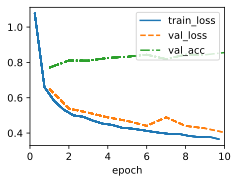

In [ ]:
trainer.fit(model_relu, data)

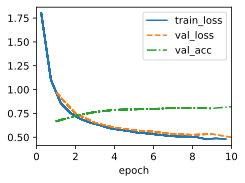

In [ ]:
trainer.fit(model_sigmoid, data)

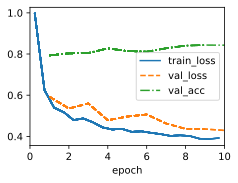

In [ ]:
trainer.fit(model_tanh, data)

#### <font color='blue'>Different activation functions have been used to train the model. These functions are ReLU, Sigmoid, and Tanh. Although the ReLU and Tanh results have similarities, overall, **ReLU worked best for this model.** ReLU introduces non-linearity to the model, allowing it to capture complex patterns in the data. At the same time, it also maintains sparsity. This combination of non-linearity and sparsity is beneficial for image recognition tasks such as the Fashion-MNIST dataset. </font>

### **6.** Is there a difference between weight initializations of the network? Does it matter?

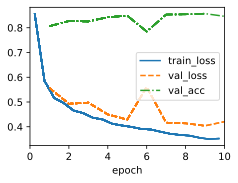

In [ ]:
# Weight initialization with random values scaled by a small sigma (sigma=0.1)
# Random initialization with a small standard deviation.
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.1):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

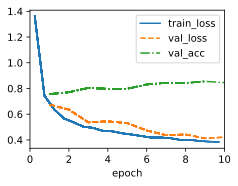

In [ ]:
# Weight initialization with random values scaled by a small sigma (sigma=0.01)
# Random initialization with a small standard deviation.
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

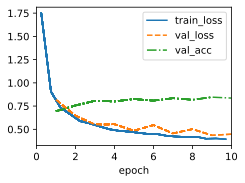

In [ ]:
# Weight initialization with random values scaled by a small sigma (sigma=0.001)
# Random initialization with a small standard deviation.
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

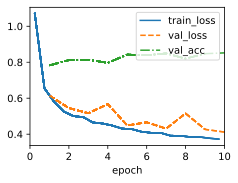

In [ ]:
# PyTorch's default weight initialization method
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

#### <font color='blue'>To test if there is a difference between weight initializations of the network, different weight initializations have been used. 3 random initializations with different sigma values and pytorch's default weight initialization method were used. Based on the results, **higher sigma values provided higher accuracy and lower loss.** Pytorch's default initialization method had lower accuracy than of the random initialization method with sigma=0.1 </font>

#### <font color='blue'>Weight initializations matter. It helps overcome issues like vanishing gradients and speed up convergence.</font>

### **7.** Let's optimize over all hyperparameters jointly, i.e., learning rate, number of epochs, number of hidden layers, and number of hidden units per layer.


#### <font color='blue'> Based on the test conducted above, a learning rate of 0.1 is the most optimal. </font>
#### <font color='blue'>Why use two hidden layers? In the context of image recognition, especially for datasets with 28x28 pixel images like Fashion-MNIST, the use of two hidden layers in an MLP can often be more beneficial compared to a single hidden layer. </font>
#### <font color='blue'> Images are highly non-linear data, and a single hidden layer may struggle to capture the complexity of non-linear relationships between pixels. </font>
#### <font color='blue'> Due to computational constraints, the joint optimization of parameters has been limited to the number of epochs and the number of hidden layers. </font>

In [ ]:
# Define an MLP model with two hidden layers.
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

In [ ]:
# Define the search space for hyperparameters
epochs_list = [10, 20, 30]
num_hiddens_list = [256, 1024, 4096, 8192]

#### Epoch = 10

In [ ]:
trainer = d2l.Trainer(max_epochs=10)

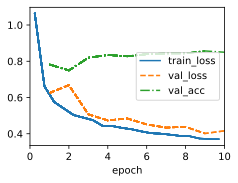

In [ ]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

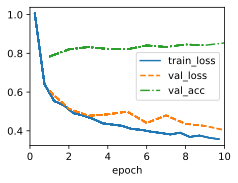

In [ ]:
model = MLP(num_outputs=10, num_hiddens=1024, lr=0.1)
trainer.fit(model, data)

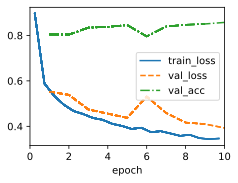

In [ ]:
model = MLP(num_outputs=10, num_hiddens=4096, lr=0.1)
trainer.fit(model, data)

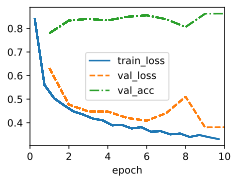

In [ ]:
model = MLP(num_outputs=10, num_hiddens=8192, lr=0.1)
trainer.fit(model, data)

#### Epoch = 20

In [ ]:
trainer = d2l.Trainer(max_epochs=20)

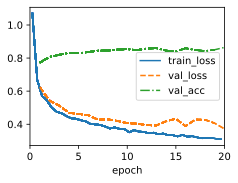

In [ ]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

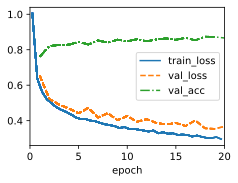

In [ ]:
model = MLP(num_outputs=10, num_hiddens=1024, lr=0.1)
trainer.fit(model, data)

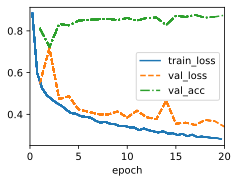

In [ ]:
model = MLP(num_outputs=10, num_hiddens=4096, lr=0.1)
trainer.fit(model, data)

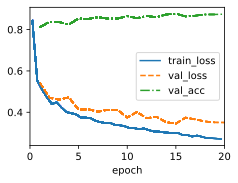

In [ ]:
model = MLP(num_outputs=10, num_hiddens=8192, lr=0.1)
trainer.fit(model, data)

#### Epoch = 30

In [ ]:
trainer = d2l.Trainer(max_epochs=30)

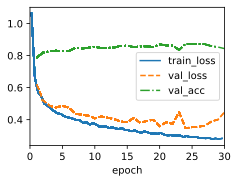

In [ ]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

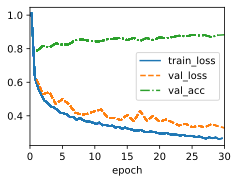

In [ ]:
model = MLP(num_outputs=10, num_hiddens=1024, lr=0.1)
trainer.fit(model, data)

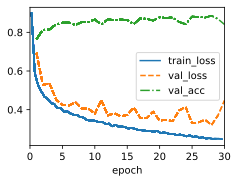

In [ ]:
model = MLP(num_outputs=10, num_hiddens=4096, lr=0.1)
trainer.fit(model, data)

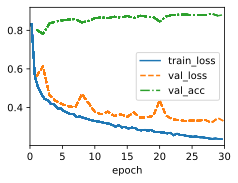

In [ ]:
model = MLP(num_outputs=10, num_hiddens=8192, lr=0.1)
trainer.fit(model, data)

#### **7.1** What is the best result you can get by optimizing over all of them?

#### <font color='blue'>Based on the conducted iteration over different hyperparameter combinations, the best hyperparameters to get the best results would be **a learning rate of 0.1, 20 epochs, 2 hidden layers, and 8192 hidden units per layer.**</font>

#### <font color='blue'> This hyperparameter combination resulted in a steady increase in accuracy above 0.8 and a steady decrease in loss below 0.6.</font>

#### **7.2** Why it is much more challenging to deal with multiple hyperparameters?

#### <font color='blue'>Dealing with multiple hyperparameters jointly is challenging because the search space grows exponentially as you add more hyperparameters.
#### Finding the best combination of hyperparameters among the provided range can be computationally expensive and time-consuming.</font>

#### **7.3** Describe an efficient strategy for optimizing over multiple parameters jointly.

#### <font color='blue'> Due to computational constraints, an efficient search has been conducted over the hyperparameters. Instead of an exhaustive exploration of the hyperparameter space, it iterated over different combinations of hyperparameters. </font>

#### <font color='blue'> Other strategies could include:

<font color='blue'><ul>
<li><b>Bayesian Optimization</b> which intelligently selects the next set of hyperparameters to evaluate based on the surrogate model's predictions.</li>
<li><b>Random Search with Heuristic Rules</b> which starts with a random search to explore a wide range of hyperparameters, and then use the results to guide a more focused search. </li>
</ul></font>
